<a href="https://colab.research.google.com/github/samuelhtampubolon/SDPM2025/blob/main/Imbalanced_Classification_Synthetic_Calibration_Cost_Curve_Prob_Histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Topik: probabilistic error, calibration (Brier), cost-sensitive thresholding
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import (average_precision_score, brier_score_loss,
                             precision_recall_curve, confusion_matrix)

In [5]:
#  Data sintetis (imbalance) + seed
seed = 1234
print("Random seed:", seed)
X, y = make_classification(
    n_samples=30000, n_features=30, n_informative=8, n_redundant=4,
    weights=[0.99, 0.01], class_sep=1.5, flip_y=0.001, random_state=seed
)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed)

print("Class balance (test)  pos rate:", y_te.mean())

Random seed: 1234
Class balance (test)  pos rate: 0.010533333333333334


In [6]:
#  Pipeline + kalibrasi (isotonic)
base = Pipeline([("scaler", StandardScaler()),
                 ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))])
cal  = CalibratedClassifierCV(estimator=base, method="isotonic", cv=3)
cal.fit(X_tr, y_tr)

proba = cal.predict_proba(X_te)[:, 1]
ap = average_precision_score(y_te, proba)
brier = brier_score_loss(y_te, proba)

print(f"Average Precision (PR-AUC): {ap:.3f}")
print(f"Brier Score (lebih kecil lebih baik): {brier:.4f}")

Average Precision (PR-AUC): 0.354
Brier Score (lebih kecil lebih baik): 0.0082


In [9]:
#  Threshold berbasis Cost
prec, rec, thr = precision_recall_curve(y_te, proba)
def conf_at_t(t):
    yh = (proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, yh).ravel()
    return tn, fp, fn, tp

cost_fp, cost_fn = 1.0, 25.0
costs = []
for t in thr[:-1]:
    tn, fp, fn, tp = conf_at_t(t)
    costs.append(cost_fp*fp + cost_fn*fn)
best_idx = int(np.argmin(costs))
best_thr = float(thr[best_idx])
tn, fp, fn, tp = conf_at_t(best_thr)

print(f"Best threshold by cost: {best_thr:.3f}")
print(f"ConfMatrix @best_thr -> TN:{tn} FP:{fp} FN:{fn} TP:{tp}")

Best threshold by cost: 0.056
ConfMatrix @best_thr -> TN:7208 FP:213 FN:9 TP:70


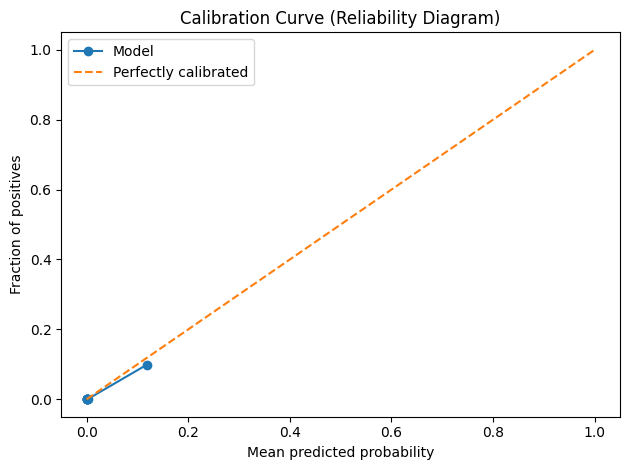

In [10]:
#  Grafik A  Reliability Diagram (Calibration Curve)
prob_true, prob_pred = calibration_curve(y_te, proba, n_bins=10, strategy="quantile")
plt.figure()
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.tight_layout()
plt.show()

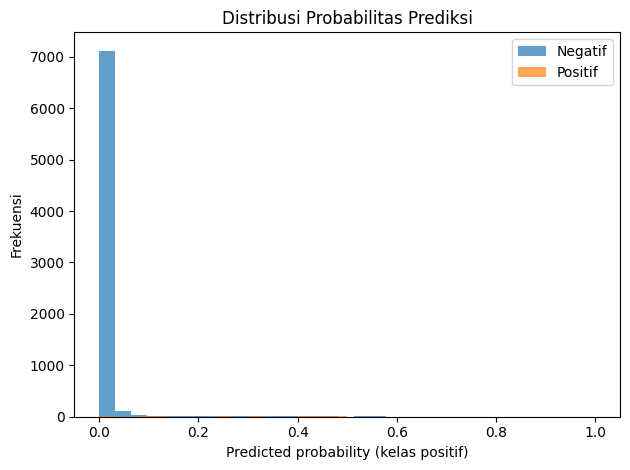

In [11]:
#  Grafik B  Histogram probabilitas (per kelas)
plt.figure()
plt.hist(proba[y_te==0], bins=30, alpha=0.7, label="Negatif")
plt.hist(proba[y_te==1], bins=30, alpha=0.7, label="Positif")
plt.xlabel("Predicted probability (kelas positif)")
plt.ylabel("Frekuensi")
plt.title("Distribusi Probabilitas Prediksi")
plt.legend()
plt.tight_layout()
plt.show()

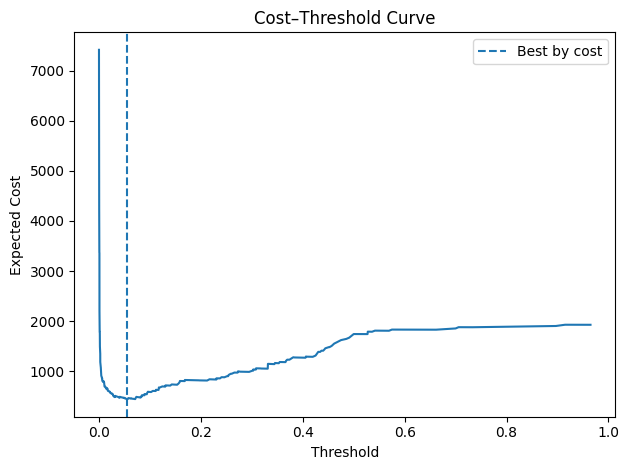

In [12]:
#  Grafik C  Cost vs Threshold
plt.figure()
plt.plot(thr[:-1], costs)
plt.axvline(best_thr, linestyle="--", label="Best by cost")
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.title("Cost–Threshold Curve")
plt.legend()
plt.tight_layout()
plt.show()